**SECTION 1: IMPORTS AND SETUP**


In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
set_seed()

**SECTION 2: FEATURE ENGINEERING**

In [10]:


df = pd.read_csv("dataset.csv")
df['week'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df = df.sort_values('week').reset_index(drop=True)
df.rename(columns={
    'week':'Date', 'facebook_spend':'Facebook_Spend', 'google_spend':'Google_Spend',
    'tiktok_spend':'TikTok_Spend', 'instagram_spend':'Instagram_Spend', 'snapchat_spend':'Snapchat_Spend',
    'social_followers':'Social_Followers', 'average_price':'Average_Price', 'promotions':'Promotions',
    'emails_send':'Emails_Send', 'sms_send':'SMS_Send', 'revenue':'Revenue'
}, inplace=True)


for col in ['Facebook_Spend','Google_Spend','TikTok_Spend','Instagram_Spend','Snapchat_Spend','Revenue']:
    df[f'log1p_{col}'] = np.log1p(df[col])


feature_cols_to_lag = [
    'Facebook_Spend', 'Google_Spend', 'TikTok_Spend',
    'Instagram_Spend', 'Snapchat_Spend', 'Promotions'
]
for col in feature_cols_to_lag:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_MA4'] = df[col].rolling(window=4).mean().shift(1)


df.head()

,Date,Facebook_Spend,Google_Spend,TikTok_Spend,Instagram_Spend,Snapchat_Spend,Social_Followers,Average_Price,Promotions,Emails_Send,...,Google_Spend_lag1,Google_Spend_MA4,TikTok_Spend_lag1,TikTok_Spend_MA4,Instagram_Spend_lag1,Instagram_Spend_MA4,Snapchat_Spend_lag1,Snapchat_Spend_MA4,Promotions_lag1,Promotions_MA4
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,...,3130.14,NaN,2993.22,NaN,1841.08,NaN,2204.72,NaN,0.0,NaN
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,...,2704.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.0,NaN
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,...,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.0,NaN
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,...,0.00,1458.535,0.00,748.305,0.00,460.27,0.00,551.18,1.0,0.25


Final Feature Creation and Cleanup

In [19]:
# drop rows with NaN
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 7)
df['month_sin'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

print("Feature engineering complete.")
print("Shape of the final dataframe:", df.shape)

Feature engineering complete.
Shape of the final dataframe: (100, 34)


**SECTION 3: DATA SPLITTING AND SCALING**

In [12]:

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


log_spend_cols = [f'log1p_{c}' for c in ['Facebook_Spend', 'TikTok_Spend', 'Instagram_Spend', 'Snapchat_Spend']]
control_cols = ['Social_Followers', 'Average_Price', 'Emails_Send', 'SMS_Send']
lag_cols = [col for col in df.columns if '_lag' in col or '_MA' in col]
cols_to_scale = log_spend_cols + control_cols + lag_cols + ['log1p_Google_Spend']
scaled_cols = [f'scaled_{c}' for c in cols_to_scale]

# fit scalers only on training data
scaler_features = RobustScaler()
scaler_revenue = RobustScaler()
scaler_features.fit(train_df[cols_to_scale])
scaler_revenue.fit(train_df[['log1p_Revenue']])

# transformation to both train and test sets
train_df[scaled_cols] = scaler_features.transform(train_df[cols_to_scale])
test_df[scaled_cols] = scaler_features.transform(test_df[cols_to_scale])
train_df['scaled_log1p_Revenue'] = scaler_revenue.transform(train_df[['log1p_Revenue']])
test_df['scaled_log1p_Revenue'] = scaler_revenue.transform(test_df[['log1p_Revenue']])
print("Data splitting and scaling complete.")

Train size: 80, Test size: 20
Data splitting and scaling complete.


**SECTION 4: ROBUST TWO-STAGE MODEL TRAINING**

In [18]:

# define features
scaled_log_spend_cols = [f'scaled_{c}' for c in log_spend_cols]
scaled_lag_cols_final = [f'scaled_{c}' for c in lag_cols]
scaled_controls_final = [f'scaled_{c}' for c in control_cols]
date_features = ['dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos']

stage1_features = scaled_log_spend_cols + scaled_lag_cols_final + scaled_controls_final + date_features
stage1_target = 'scaled_log1p_Google_Spend'


print("Creating robust Stage 2 feature using cross-validation.")
tscv = TimeSeriesSplit(n_splits=4)
train_df['pred_google_spend_cv'] = 0.0

for train_indices, val_indices in tscv.split(train_df):
    fold_train_df, fold_val_df = train_df.iloc[train_indices], train_df.iloc[val_indices]

    # train a temporary model
    temp_model_s1 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    temp_model_s1.fit(fold_train_df[stage1_features], fold_train_df[stage1_target])

    # predict on the validation part of the fold
    val_preds = temp_model_s1.predict(fold_val_df[stage1_features])
    train_df.loc[fold_val_df.index, 'pred_google_spend_cv'] = val_preds


train_df[['scaled_log1p_Google_Spend', 'pred_google_spend_cv']].tail()

Creating robust Stage 2 feature using cross-validation.


,scaled_log1p_Google_Spend,pred_google_spend_cv
75,1.024774,0.156222
76,0.998341,0.099194
77,1.007989,0.009803
78,0.000000,0.293722
79,0.000000,0.208652


Final Model Training

Now, we train the final two models.

Stage 1 Model: Trained on all training data to predict Google Spend on the unseen test set.

Stage 2 Model: Trained on the training data using the pred_google_spend_cv feature to predict final revenue.

In [14]:
# define stage 2 features
stage2_features = scaled_log_spend_cols + ['pred_google_spend_cv'] + scaled_lag_cols_final + scaled_controls_final + date_features
stage2_target = 'scaled_log1p_Revenue'

print("Training final models...")
# final stage 1 model
final_model_s1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42)
final_model_s1.fit(train_df[stage1_features], train_df[stage1_target])
test_df['pred_google_spend_cv'] = final_model_s1.predict(test_df[stage1_features])
print("Final Stage 1 model trained.")

# final stage 2 model
final_model_s2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42)
final_model_s2.fit(train_df[stage2_features], train_df[stage2_target])
print("Final Stage 2 model trained.")

Training final models...
Final Stage 1 model trained.
Final Stage 2 model trained.


**SECTION 5: FINAL EVALUATION**

In [17]:

print("Final Evaluation on Hold-Out Test Set")
final_preds_scaled = final_model_s2.predict(test_df[stage2_features])


def safe_inverse_transform(scaled_vals, scaler_obj):
    scaled_vals = np.array(scaled_vals).astype(np.float64).ravel().reshape(-1, 1)
    inv_transformed = scaler_obj.inverse_transform(scaled_vals)
    original_vals = np.expm1(np.clip(inv_transformed, 0, None)) # Use expm1 and clip
    return original_vals.ravel()

test_preds_orig = safe_inverse_transform(final_preds_scaled, scaler_revenue)
test_targets_orig = safe_inverse_transform(test_df['scaled_log1p_Revenue'].values, scaler_revenue)


rmse = np.sqrt(mean_squared_error(test_targets_orig, test_preds_orig))
mae = mean_absolute_error(test_targets_orig, test_preds_orig)
r2 = r2_score(test_targets_orig, test_preds_orig)

print(f"\nFinal Test RMSE on Revenue (original scale): ${rmse:,.2f}")
print(f"Final Test MAE on Revenue (original scale):  ${mae:,.2f}")
print(f"Final Test R-squared on Revenue (original scale): {r2:.3f}")

Final Evaluation on Hold-Out Test Set

Final Test RMSE on Revenue (original scale): $30,192.19
Final Test MAE on Revenue (original scale):  $15,617.00
Final Test R-squared on Revenue (original scale): 0.711


**SECTION 6: ANALYZE MODEL INSIGHTS**

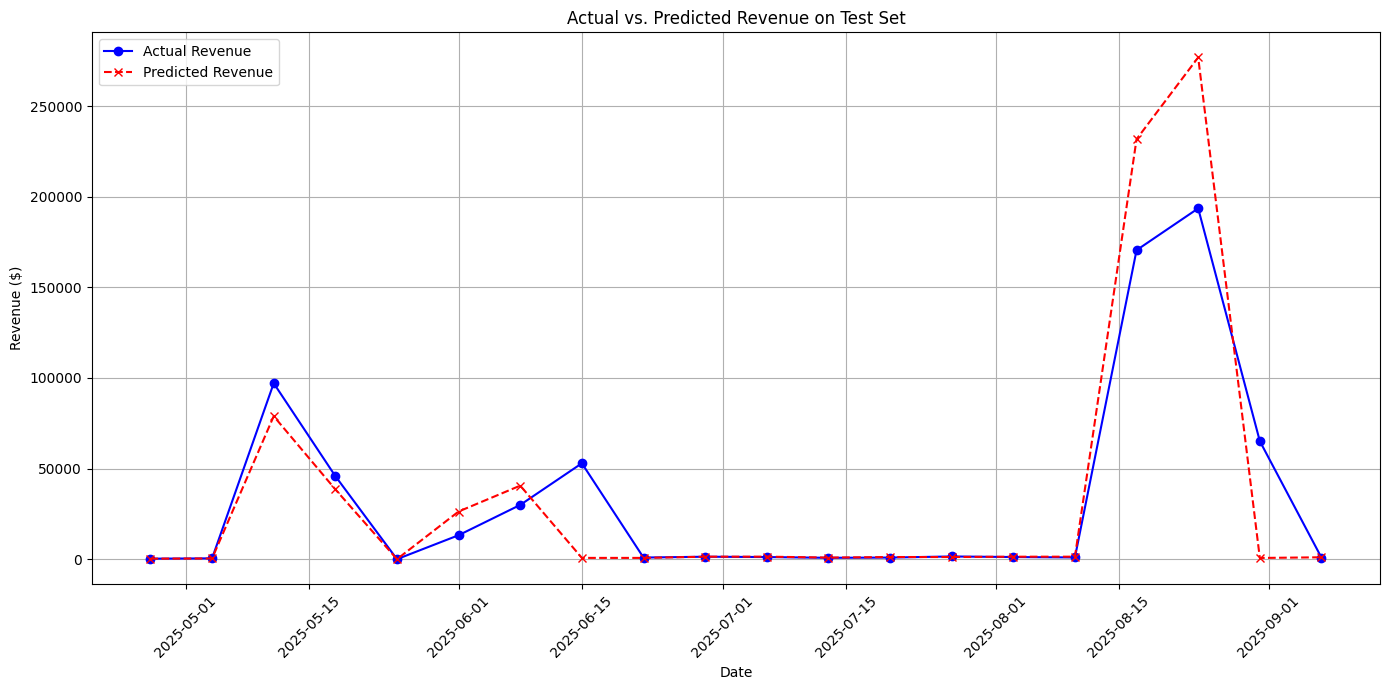

In [21]:

plt.figure(figsize=(14, 7))
plt.plot(test_df['Date'], test_targets_orig, label='Actual Revenue', marker='o', linestyle='-',color="blue")
plt.plot(test_df['Date'], test_preds_orig, label='Predicted Revenue', marker='x', linestyle='--',color="red")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.title("Actual vs. Predicted Revenue on Test Set")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**SECTION 7: DEEPER DIAGNOSTICS & BUSINESS INSIGHTS**

Residual Analysis

Deeper Diagnostics: Residual Analysis


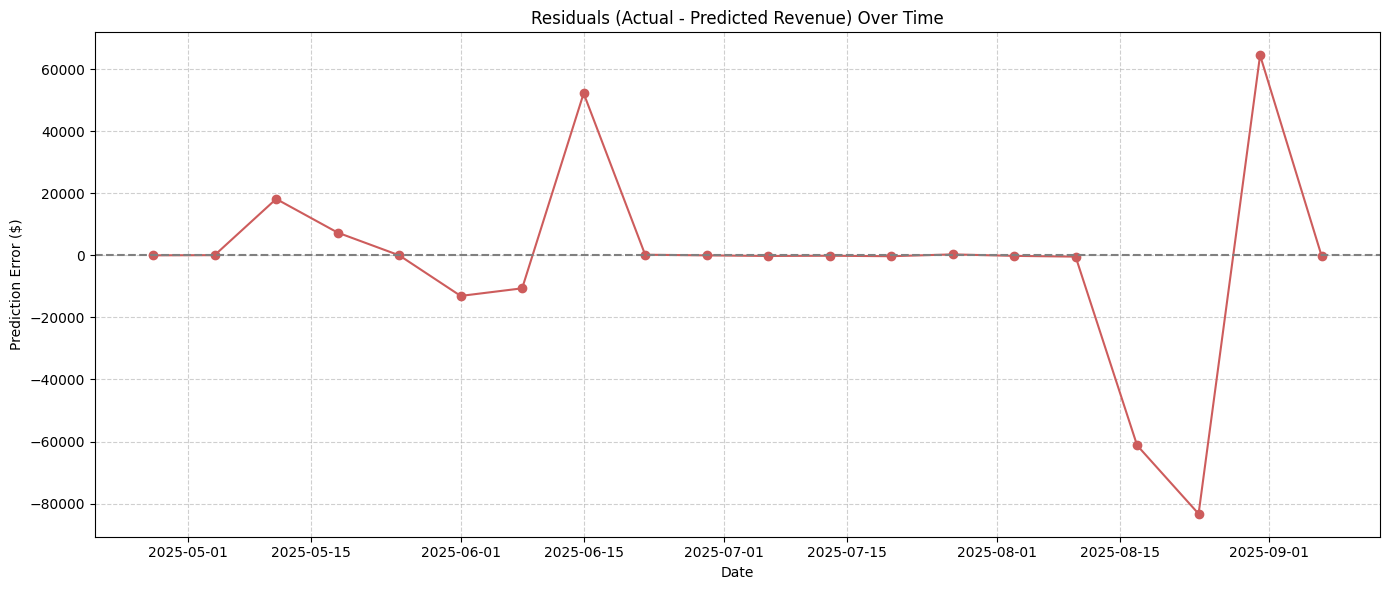

In [26]:

residuals = test_targets_orig - test_preds_orig

print("Deeper Diagnostics: Residual Analysis")
plt.figure(figsize=(14, 6))
plt.plot(test_df['Date'], residuals, marker='o', linestyle='-', color='indianred')
plt.axhline(y=0, color='grey', linestyle='--')
plt.title("Residuals (Actual - Predicted Revenue) Over Time")
plt.xlabel("Date")
plt.ylabel("Prediction Error ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Hypothetical Scenario Simulation

In [25]:

print("Business Insights: Hypothetical Scenario Simulation")

sim_df = test_df.copy()

print("Simulating a 15% increase in TikTok spend for the test period...")
sim_df['TikTok_Spend'] = sim_df['TikTok_Spend'] * 1.15
sim_df['log1p_TikTok_Spend'] = np.log1p(sim_df['TikTok_Spend'])

scaled_sim_features = scaler_features.transform(sim_df[cols_to_scale])

sim_df[scaled_cols] = scaled_sim_features

sim_google_spend_scaled = final_model_s1.predict(sim_df[stage1_features])
sim_df['pred_google_spend_cv'] = sim_google_spend_scaled

sim_revenue_scaled = final_model_s2.predict(sim_df[stage2_features])

sim_revenue_orig = safe_inverse_transform(sim_revenue_scaled, scaler_revenue)

original_predicted_total_revenue = test_preds_orig.sum()
simulated_total_revenue = sim_revenue_orig.sum()
revenue_lift = simulated_total_revenue - original_predicted_total_revenue
percent_lift = (revenue_lift / original_predicted_total_revenue) * 100 if original_predicted_total_revenue != 0 else 0

print(f"Original Model Predicted Revenue for Test Period: ${original_predicted_total_revenue:,.2f}")
print(f"Simulated Revenue (with +15% TikTok Spend):     ${simulated_total_revenue:,.2f}")
print(f"Estimated Revenue Lift from this change:          ${revenue_lift:,.2f} ({percent_lift:.2f}%)")

Business Insights: Hypothetical Scenario Simulation
Simulating a 15% increase in TikTok spend for the test period...
Original Model Predicted Revenue for Test Period: $705,255.76
Simulated Revenue (with +15% TikTok Spend):     $705,284.06
Estimated Revenue Lift from this change:          $28.30 (0.00%)
